## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5-1. Modeling 1 - RPI Prediction - XGBoost

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5-1. Modeling (1) RPI prediction based on stats - XGboost
- Step 5-2. Modeling (1) RPI prediction based on stats - Linear regression

In [4]:
import pickle 

import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats

from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [13]:
%store -r y_RPI
%store -r y_RPI_2019
%store -r X_famd
%store -r X_famd_2019
%store -r X_College
%store -r X_College_2019
%store -r X_2019
%store -r X

In [23]:
columns_categorical = X.columns[list(range(16,48))]
columns_categorical
for idx,col in enumerate(columns_categorical):
    X[col] = X[col].astype(int)
    X_2019[col] = X_2019[col].astype(int)

print(X.dtypes)
print(X_2019.dtypes)

Year                                 float64
Fielding_Percentage                  float64
Scoring                              float64
Hit_Batters                          float64
Earned_Run_Average                   float64
Triples_per_Game                     float64
Home_Runs_per_game                   float64
Slugging_Percentage                  float64
Double_Plays_per_Game                float64
On_Base_Percentage                   float64
Stolen_Bases_per_Game                float64
Strikeout-to-Walk_Ratio              float64
Batting_Average                      float64
Doubles_per_Game                     float64
Shutouts                             float64
Team_Strikeouts_Per_Seven_Innings    float64
Conf__ACC                              int64
Conf__ASUN                             int64
Conf__America East                     int64
Conf__Atlantic 10                      int64
Conf__Big 12                           int64
Conf__Big East                         int64
Conf__Big 

In [24]:
X = X.drop(columns=['Year'])
X_2019 = X_2019.drop(columns=['Year'])

In [25]:
y_RPI.to_csv('Data/y_RPI.csv',index=False)
y_RPI_2019.to_csv('Data/y_RPI_2019.csv',index=False)
X.to_csv('Data/X.csv',index=False)
X_2019.to_csv('Data/X_2019.csv',index=False)
X_famd.to_csv('Data/X_famd.csv',index=False)
X_famd_2019.to_csv('Data/X_famd_2019.csv',index=False)
X_College.to_csv('Data/X_College.csv',index=False)
X_College_2019.to_csv('Data/X_College_2019.csv',index=False)

In [6]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [46]:
y = y_RPI
X = X_famd.copy()
X.head()

0         1         2         3         4         5         6   \
297  2.170850 -0.027647  0.127369  1.219246  0.368641 -0.196787 -0.130418   
298  2.494396 -0.349768 -0.344156 -0.027539 -0.393484 -0.083979 -0.645833   
299  2.457301 -0.283095 -0.206933 -0.126478 -0.400174  0.167933 -0.737496   
300  2.908420 -0.812397 -0.120084 -0.298639  0.672517  0.069064  0.087966   
301  2.452516 -0.725179 -0.179109 -0.183864 -0.318930  0.200328 -0.708240   

           7         8         9         10        11        12        13  \
297 -0.171609 -0.352457  0.058697 -0.383129  0.073038  1.005647  0.595547   
298  1.197497 -0.807566  0.329022 -0.167865 -0.454194  0.645177  0.477687   
299  1.330876 -0.816391  0.307917 -0.206095 -0.494546  0.657509  0.443358   
300  0.139732  0.310211  0.063894  0.114614 -0.022350  0.665968  0.105203   
301  1.214912 -0.771176  0.350310 -0.168707 -0.451476  0.672903  0.490794   

           14        15        16        17        18        19        20  \
297  0.468127 -0.074023 -0.904480  0.720769 -0.207444 -0.485857 -0.214408   
298 -0.396526  0.407270  0.098008 -0.408822  0.217627  0.550522  0.343296   
299 -0.414156  0.395289  0.065043 -0.445311  0.208540  0.538905  0.336216   
300 -0.150634 -0.645803  0.153987 -0.398356  0.099389  0.377348  0.142229   
301 -0.377889  0.386218  0.058440 -0.463347  0.218717  0.552809  0.343879   

           21        22        23        24        25        26        27  \
297 -0.676500 -0.153969 -0.128498 -0.310688 -0.043215  0.134537  0.032437   
298  0.310762 -0.242690  0.102283  0.435957  0.295430 -0.019137 -0.204928   
299  0.306693 -0.206007  0.090296  0.440320  0.308226 -0.028989 -0.224333   
300  0.649320  0.818685  0.093924 -0.460005 -1.153012 -0.532278  1.535312   
301  0.272640 -0.235689  0.091781  0.435474  0.315789 -0.024178 -0.214399   

           28        29        30        31        32        33        34  \
297 -0.287246  0.018377  0.098459 -0.270373 -0.335707 -0.448651  0.572197   
298  0.257748 -0.033217 -0.076521  0.637219 -0.116861 -0.095138  0.027686   
299  0.258356 -0.020713 -0.057799  0.639894 -0.185656 -0.244586 -0.110804   
300 -0.473104  0.152722 -0.480115  0.391411 -0.465212  0.441163 -0.201934   
301  0.252061 -0.025570 -0.038579  0.615931 -0.221270 -0.344349 -0.016926   

           35        36        37        38        39        40        41  \
297  0.410523 -0.068122 -0.046195  0.043469 -0.303446 -0.294815 -0.532836   
298  0.371716  0.534058  0.189141 -0.112994 -0.270728 -0.008564 -0.010155   
299 -0.140564  0.020098  0.134771 -0.115916 -0.294089  0.135937  0.302643   
300  0.192078  0.115855  0.443823 -0.596109 -0.125310  0.085299  0.075666   
301  0.053174  0.357887 -0.270456 -0.212351 -0.516283 -0.072864 -0.125879   

           42        43        44        45        46  
297  0.235490 -0.178836 -0.052232 -0.010824  0.022264  
298  0.190365  0.201579 -0.095771 -0.000673  0.000086  
299  0.244900  0.082033 -0.046263 -0.009489 -0.004715  
300  0.421896  0.160937  0.093301 -0.004882  0.025164  
301  0.404643  0.165810 -0.036130  0.006442 -0.008450

In [127]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train = X_famd
y_train = y_RPI
X_test = X_famd_2019
y_test = y_RPI_2019

#X_train = X_famd
#y_train = np.log(y_RPI/max(y_RPI)/(1-y_RPI/max(y_RPI)))
#X_test = X_famd_2019
#y_test = np.log(y_RPI_2019/max(y_RPI_2019)/(1-y_RPI_2019/max(y_RPI_2019)))


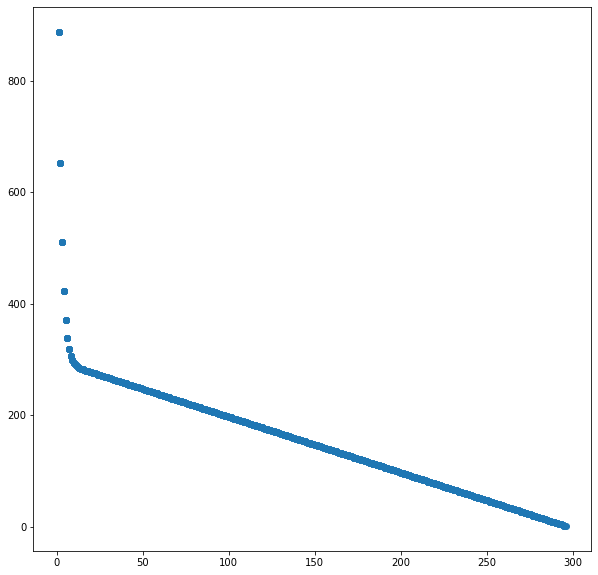

In [220]:
#sample weight
w = max(y_RPI)- y_RPI + 1

w = (2*np.exp(-0.5*(y_RPI-1)) + 1) * w
plt.scatter(y_RPI,w)

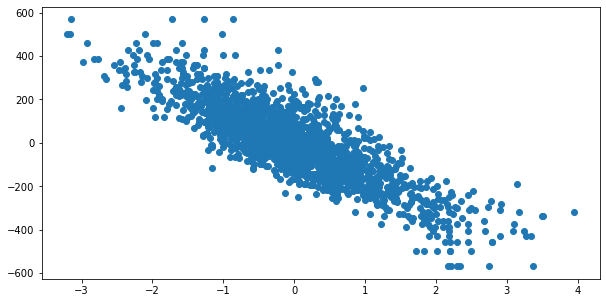

In [71]:
plt.scatter(X_train[0],y_train)

In [221]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1],
    'tweedie_variance_power':[1, 1.2, 1.4, 1.6, 1.8, 2]
}

xg_reg = xgb.XGBRegressor(objective ='reg:tweedie',nthread= -1,gpu_id=-1)

In [222]:
folds = 5
param_comb = 100

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=1,
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train,sample_weight = w)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/koeunlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [ -39.38714416 -131.99186855  -38.7812339   -37.73334403  -41.59200662
  -37.18656982  -82.23641918  -73.61811077  -38.3074063  -154.69070647
  -55.51565436  -37.03400519  -38.18537379  -39.76659868  -52.11722277
  -98.70266582           nan  -38.30449489 -158.515868             nan
  -65.75834856           nan           nan  -38.59246559           nan
 -137.56904074  -48.20579113  -39.71039791  -61.30600488  -42.79820512
           nan  -50.98409373           nan  -36.8450405            nan
  -37.23946689           nan           nan  -93.74182336  -38.96355366
  -36.73588602  -44.19677099 -168.47112717           nan           nan
  -43.60763332  -38.39342212           nan           nan  -43.44018312
  -38.10198546           nan -112.88008164           nan  -83.62883357
           nan -230.90975402  -56.92231147  -40.65155283  -50


 Time taken: 0 hours 6 minutes and 7.08 seconds.


In [223]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X_train)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd_exp_kevin.csv', index=False)


 All results:
{'mean_fit_time': array([6.36682925, 3.96505809, 3.40976963, 2.94790316, 7.27937946,
       5.01806197, 1.1655015 , 4.92472882, 4.01965537, 6.36930079,
       2.97699184, 3.36930432, 2.97798324, 3.25220046, 2.55093265,
       3.74243126, 0.03035054, 1.14904599, 1.1527267 , 0.0356658 ,
       3.71857219, 0.02724972, 0.90395656, 1.82334347, 0.0258954 ,
       0.93868794, 5.1505568 , 2.0649148 , 8.35315666, 7.6207231 ,
       0.02955952, 2.80744262, 0.90722499, 3.94729414, 0.02822342,
       2.68957996, 0.84558916, 1.04186268, 4.50219693, 1.58749924,
       3.857763  , 4.07803984, 1.79021244, 2.23020253, 0.03851404,
       1.95427208, 5.39715023, 0.03942623, 1.68049579, 3.58239031,
       3.27733984, 0.02605839, 0.99505467, 0.03088369, 1.21041412,
       0.72440548, 9.81735106, 6.11882176, 9.85172677, 1.39792619,
       3.96542811, 2.87574759, 3.57520437, 7.59095402, 4.71410189,
       0.03013864, 0.03087807, 3.31204   , 0.03277903, 1.42722025,
       1.00417995, 0.8254446 



Best Train R_squared 5-fold search with 100 parameter combinations:
0.9742638256209194


Best Test R_squared 5-fold search with 100 parameter combinations:
0.8340938848200585


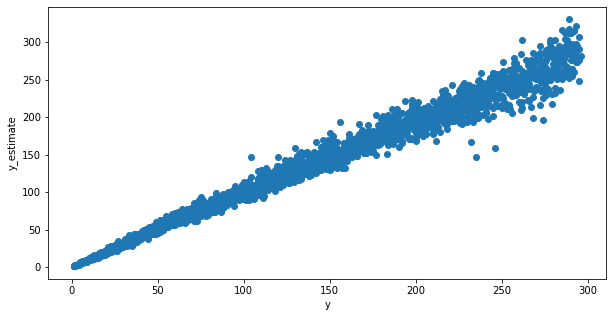

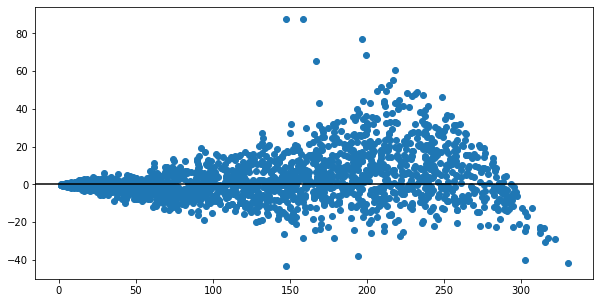

In [224]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X),y-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

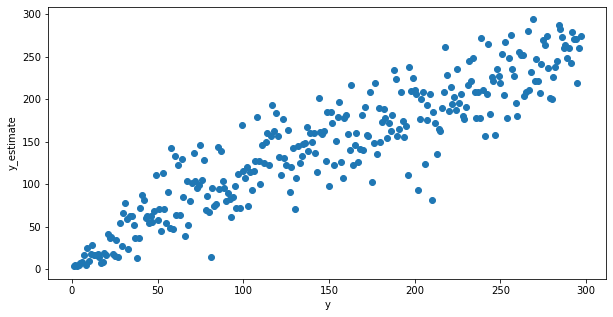

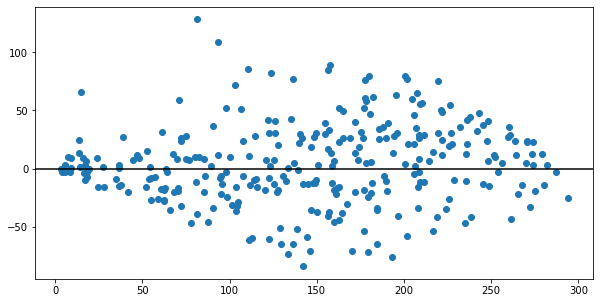

In [225]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y_test,random_search1.predict(X_test))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X_test),y_test-random_search1.predict(X_test))
plt.axhline(color='black')
plt.show()

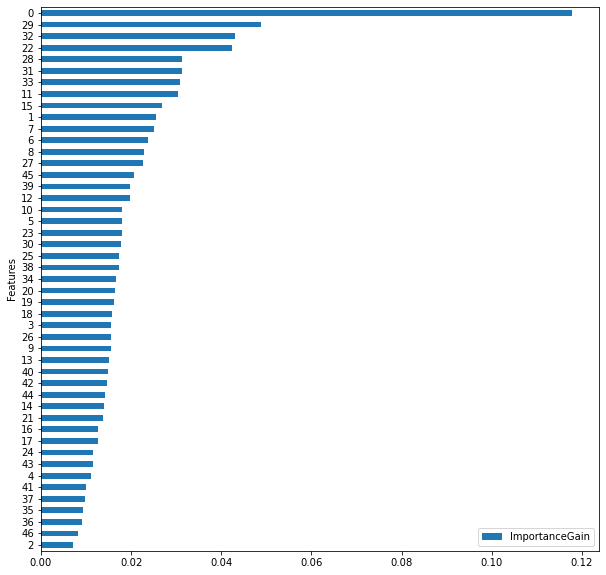

Features  ImportanceGain  CummulativeGain
0          0        0.117893         0.117893
29        29        0.048726         0.166619
32        32        0.043081         0.209700
22        22        0.042455         0.252156
28        28        0.031268         0.283424
31        31        0.031264         0.314687
33        33        0.030739         0.345426
11        11        0.030358         0.375784
15        15        0.026775         0.402559
1          1        0.025558         0.428117
7          7        0.025005         0.453122
6          6        0.023750         0.476873
8          8        0.022826         0.499698
27        27        0.022696         0.522394
45        45        0.020631         0.543025
39        39        0.019772         0.562797
12        12        0.019705         0.582503
10        10        0.017993         0.600495
5          5        0.017921         0.618416
23        23        0.017903         0.636320
30        30        0.017822         0.654141
25        25        0.017318         0.671459
38        38        0.017244         0.688703
34        34        0.016584         0.705287
20        20        0.016362         0.721649
19        19        0.016146         0.737795
18        18        0.015752         0.753546
3          3        0.015591         0.769138
26        26        0.015590         0.784728
9          9        0.015528         0.800255
13        13        0.015093         0.815348
40        40        0.014785         0.830133
42        42        0.014596         0.844729
44        44        0.014181         0.858910
14        14        0.014069         0.872980
21        21        0.013707         0.886687
16        16        0.012719         0.899406
17        17        0.012660         0.912066
24        24        0.011611         0.923676
43        43        0.011507         0.935183
4          4        0.011066         0.946249
41        41        0.010060         0.956309
37        37        0.009844         0.966153
35        35        0.009343         0.975496
36        36        0.009166         0.984662
46        46        0.008161         0.992823
2          2        0.007177         1.000000

In [226]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1

### Bootstrap resampling to obtain the predicted RPI distribution

In [227]:
print(random_search1.best_estimator_)
print(random_search1.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:tweedie', random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=None, subsample=0.8, tree_method='exact',
             tweedie_variance_power=1.4, validate_parameters=1, verbosity=None)
{'tweedie_variance_power': 1.4, 'subsample': 0.8, 'reg_alpha': 0, 'random_state': 1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 1.0}


In [228]:
best_xgbmodel = random_search1.best_estimator_
best_xgbmodel.fit(X_train,y_train,sample_weight = w)
fname = 'XGBoost_RPI/xgbmodel_rpi_exp_kevin.obj'
file = open(fname,'wb')
pickle.dump(best_xgbmodel,file)

In [229]:
# boostrap resampling to generate prediction probability
n_bootstrap = 100
best_xgbmodel_i = random_search1.best_estimator_

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    idx_resample =  resample(range(len(y_train)), replace=True, n_samples=len(y_train))
    X_i = X_train.iloc[idx_resample]
    y_i = y_train.iloc[idx_resample]
    w_i = w.iloc[idx_resample]
    best_xgbmodel_i.fit(X_i,y_i,sample_weight = w_i)
    y_ex_est = pd.Series(best_xgbmodel_i.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    #fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    #file_i = open(fname_i,'wb')
    #pickle.dump(best_xgbmodel,file_i)

df_y_ex.columns = X_College_2019

In [10]:
'''
n_bootstrap = 100

y_ex = y_test
X_ex = pd.DataFrame(X_test)
df_y_ex = pd.DataFrame()
for i_b in range(n_bootstrap):
    fname_i = 'XGBoost_RPI/xgbmodel_rpi_bs_' + str(i_b) + '.obj'
    file_i = open(fname_i,'rb')
    best_xgbmodel = pickle.load(file_i)
    y_ex_est = pd.Series(best_xgbmodel.predict(X_ex))
    df_y_ex = df_y_ex.append(y_ex_est,ignore_index = True)
    
df_y_ex.columns = X_College_2019
'''

In [230]:
df_y_rank = df_y_ex.rank(axis=1)
df_y_rank
df_y_rank.to_csv('XGBoost_RPI/RPI_prediction_kevin.csv',index = False)

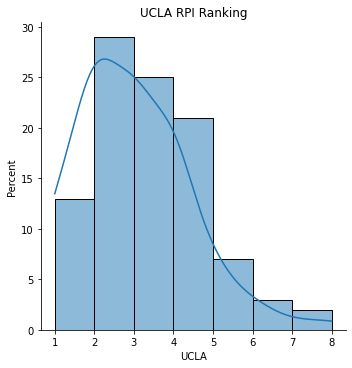

Actual rank:  2.0
Predicted rank:  2.0


In [234]:
idx_ex = 1
college = df_y_rank.columns[idx_ex]
bins = int(np.max(df_y_rank[college]) - np.min(df_y_rank[college]))
sn.displot(data=df_y_rank,x=college,kde=True,bins=bins) 
plt.title(college + ' RPI Ranking')
plt.ylabel('Percent')
plt.show()
print('Actual rank: ', y_ex[idx_ex])
print('Predicted rank: ',df_y_rank[college].value_counts().index[0:2].min())

In [144]:
df_y_rank

College  Oklahoma  UCLA  Washington  Arizona  Florida State  Alabama  \
0             1.0   3.0         2.0     10.0            4.0     14.0   
1             4.0   1.0         2.0      3.0           11.0     10.0   
2             5.0   2.0         1.0      4.0            3.0     13.0   
3             3.0   4.0         1.0      2.0            7.0      9.0   
4             1.0   3.0         5.0      6.0            2.0     10.0   
5             1.0   3.0         2.0      5.0            8.0      6.0   
6             3.0   6.0         2.0      5.0            1.0     12.0   
7             3.0   2.0         1.0      4.0            6.0     14.0   
8             3.0   2.0         1.0      6.0            4.0      9.0   
9             3.0   2.0         1.0      5.0           11.0      9.0   
10           11.0   2.0         1.0      4.0            5.0     10.0   
11            7.0   2.0         1.0      3.0           12.0      6.0   
12            2.0   3.0         1.0      6.0            8.0     10.0   
13            2.0   4.0         1.0      5.0            3.0     11.0   
14            2.0   1.0         3.0      4.0            8.0      9.0   
15            1.0   4.0         2.0      6.0            7.0     14.0   
16            3.0   5.0         1.0      6.0            2.0     12.0   
17            2.0   3.0         1.0      4.0            6.0     10.0   
18            1.0   5.0         2.0      3.0            7.0     10.0   
19            4.0   1.0         2.0      3.0            5.0     11.0   
20            4.0   2.0         3.0      5.0            1.0     10.0   
21            3.0   2.0         1.0      7.0            5.0      4.0   
22            1.0   3.0         2.0      6.0            5.0     15.0   
23            4.0   2.0         1.0      5.0            3.0     15.0   
24            1.0   5.0         4.0      6.0            2.0      9.0   
25            3.0   1.0         2.0      7.0            6.0     11.0   
26            6.0   3.0         1.0      7.0            2.0     13.0   
27            4.0   3.0         1.0      2.0           13.0     11.0   
28            8.0   3.0         1.0      4.0            5.0     12.0   
29            3.0   2.0         1.0      4.0            9.0     10.0   
30            5.0   1.0         2.0      3.0            6.0     13.0   
31            2.0   3.0         1.0      6.0            4.0     10.0   
32            6.0   2.0         1.0      3.0            4.0     11.0   
33            1.0   3.0         2.0      4.0            5.0     11.0   
34            7.0   3.0         2.0      4.0            1.0     11.0   
35            4.0   1.0         2.0      9.0           12.0      5.0   
36            1.0   3.0         4.0      2.0            8.0      6.0   
37            1.0   3.0         2.0      4.0            5.0     13.0   
38            1.0   4.0         2.0      6.0            3.0     11.0   
39            3.0   4.0         1.0      7.0            6.0     10.0   
40            1.0   3.0         2.0      8.0           10.0     11.0   
41            2.0   4.0         1.0      8.0            7.0     10.0   
42            6.0   2.0         1.0      5.0            3.0      7.0   
43            2.0   3.0         1.0      4.0            5.0      9.0   
44            3.0   2.0         1.0      8.0            4.0      9.0   
45            4.0   1.0         2.0      3.0           13.0      9.0   
46            1.0   4.0         2.0      3.0           12.0      8.0   
47            7.0   3.0         1.0      2.0            4.0      9.0   
48            4.0   3.0         1.0      2.0            5.0     12.0   
49            1.0   4.0         3.0      2.0            6.0     13.0   
50            8.0   3.0         1.0      6.0            4.0     12.0   
51            2.0   4.0         1.0      3.0            6.0      7.0   
52            1.0   3.0         2.0      8.0            5.0     10.0   
53            4.0   2.0         1.0      7.0           10.0     11.0   
54           10.0   1.0         2.0     

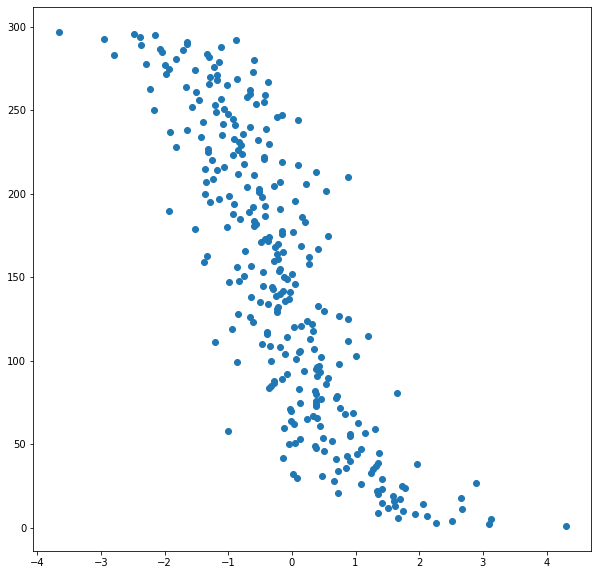

In [115]:
plt.scatter(X_famd_2019[0],y_RPI_2019)

In [43]:
y_prop = y_RPI_2019.copy()/max(y_RPI_2019.copy())
y_scaled = np.log(y_prop/(1-y_prop))


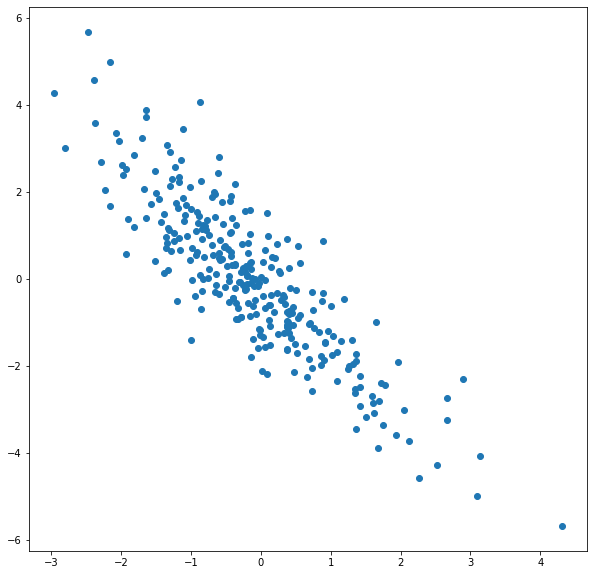

In [116]:
plt.scatter(X_famd_2019[0],y_scaled)

In [173]:
df_y_rank[college].value_counts().index[0:2].min()

1.0